In [3]:
import torch
import torch.nn as nn
import numpy as np

In [4]:
# input: (batch_size, 25, 25, 25)
# output: (batch_size)
# 3d convolution
class Discriminator(nn.Module):
    def __init__(self, n_feature_map=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(n_feature_map / 8)
        conv2_channels = int(n_feature_map / 4)
        conv3_channels = int(n_feature_map / 2)
        conv4_channels = int(n_feature_map / 1)
        self._conv4_channels = conv4_channels
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
                nn.LeakyReLU(0.2, inplace=True),
                nn.BatchNorm3d(out_channels),
            )
            
        # input (batch_size, 1, 25, 25, 25)
        # output (batch_size, conv1_channels, 23, 23, 23)
        self._conv1 = conv_block(1, conv1_channels)
        # input (batch_size, conv1_channels, 23, 23, 23)
        # output (batch_size, conv2_channels, 21, 21, 21)
        self._conv2 = conv_block(conv1_channels, conv2_channels)
        # input (batch_size, conv2_channels, 21, 21, 21)
        # output (batch_size, conv3_channels, 19, 19, 19)
        self._conv3 = conv_block(conv2_channels, conv3_channels)    
        # input (batch_size, conv3_channels, 19, 19, 19)
        # output (batch_size, conv4_channels, 17, 17, 17)
        self._conv4 = conv_block(conv3_channels, conv4_channels)
        # input (batch_size, conv4_channels, 17, 17, 17)
        # output (batch_size, 1)
        self._linear = nn.Sequential(
            nn.Linear(17 * 17 * 17 * conv4_channels, 1), # FIXME: hardcoded
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x = self._conv4(x)
        x = x.view(-1, 17 * 17 * 17 * self._conv4_channels) # FIXME: hardcoded
        x = self._linear(x)
        return x

In [5]:
# Discri test
D_test = Discriminator()

import DataSetECAL
dataset = DataSetECAL.DataSetECAL('/Users/yuto/VS/3d_calo_gan/gan/data/dataloader/test_01_0_pickle')
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
)
x = next(iter(data_loader)).float()
x = x.view(8, 1, 25, 25, 25)

D_test.forward(x).shape


torch.Size([8, 1])

In [6]:
class Generator(nn.Module):
    def __init__(self, n_feature_map=512, latent_dim=200):
        super(Generator, self).__init__()
        self._n_feature_map = n_feature_map
        self._latent_dim = latent_dim
        self._deconv1_channels = int(n_feature_map / 1)
        self._deconv2_channels = int(n_feature_map / 2)
        self._deconv3_channels = int(n_feature_map / 4)
        self._deconv4_channels = int(n_feature_map / 8)
        
        def deconv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=False),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True),
            )
        
        # input (batch_size, latent_dim)
        # output (batch_size, self._deconv1_channels * 17 * 17 * 17)
        self._linear = nn.Linear(latent_dim, self._deconv1_channels * 17 * 17 * 17)
        # input (batch_size, self._deconv1_channels, 17, 17, 17)
        # output (batch_size, self._deconv2_channels, 19, 19, 19)
        self._deconv1 = deconv_block(self._deconv1_channels, self._deconv2_channels)
        # input (batch_size, self._deconv2_channels, 19, 19, 19)
        # output (batch_size, self._deconv3_channels, 21, 21, 21)
        self._deconv2 = deconv_block(self._deconv2_channels, self._deconv3_channels)
        # input (batch_size, self._deconv3_channels, 21, 21, 21)
        # output (batch_size, self._deconv4_channels, 23, 23, 23)
        self._deconv3 = deconv_block(self._deconv3_channels, self._deconv4_channels)
        # input (batch_size, self._deconv4_channels, 23, 23, 23)
        # output (batch_size, 1, 25, 25, 25)
        self._deconv4 = deconv_block(self._deconv4_channels, 1)
        # activation
        self._activation = nn.Sigmoid()
        
    # input (batch_size, self._deconv1_channels * 17 * 17 * 17)
    # output (batch_size, deconv1_channels, 17, 17, 17)
    def _vec2cube(self, x):
        return x.view(-1, self._deconv1_channels, 17, 17, 17)
    
    def forward(self, x):
        x = self._linear(x)
        x = self._vec2cube(x)
        x = self._deconv1(x)
        x = self._deconv2(x)
        x = self._deconv3(x)
        x = self._deconv4(x)
        x = self._activation(x)
        return x

In [7]:
# Generator test
z_test = torch.randn(8, 200)
g_test = Generator()
sample01 = g_test(z_test)
sample01 = sample01[0].view(25, 25, 25)

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# xyz.shape = (25, 25, 25)
def draw_sample(xyz, ax):
    """
    input shape = (25, 25, 25)
    """
    xyz = xyz.detach().cpu().numpy()
    x = np.zeros(25 * 25 * 25)
    y = np.zeros(25 * 25 * 25)
    z = np.zeros(25 * 25 * 25)
    e = xyz.reshape(25 * 25 * 25)
    n_split = xyz.shape[0]
    counter = 0
    for ix in range(n_split):
        for iy in range(n_split):
            for iz in range(n_split):
                x[counter] = ix
                y[counter] = iy
                z[counter] = iz
                counter += 1
                
    marker_size = (e / np.linalg.norm(e)) ** 2
    print(f'e.sum() = {e.sum()}, marker_size.sum() = {marker_size.sum()}')
    img = ax.scatter(x, y, z, c=e, s=marker_size*500, cmap='jet')
    #ax.colorbar(img)

def draw_some_samples(xyz_s, n_show=4, figsize=(10, 10)):
    batch_size = xyz_s.shape[0]
    if batch_size < n_show:
        raise ValueError('batch_size must be larger than n_show')
    fig = plt.figure(figsize=figsize)
    for i in range(n_show):
        ax = fig.add_subplot(1, 4, i+1, projection='3d')
        draw_sample(xyz_s[i], ax)

e.sum() = 577070366720.0, marker_size.sum() = 1.0
e.sum() = 386952953856.0, marker_size.sum() = 0.9999997615814209
e.sum() = 267466899456.0, marker_size.sum() = 1.0000001192092896
e.sum() = 898210988032.0, marker_size.sum() = 1.0000001192092896


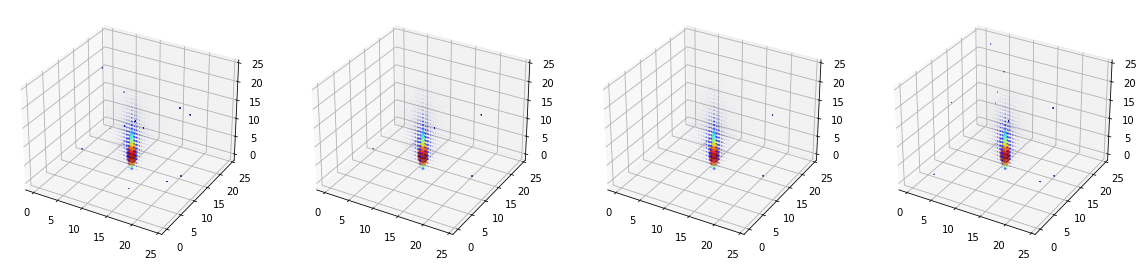

In [23]:
dataset = DataSetECAL.DataSetECAL('/Users/yuto/VS/3d_calo_gan/gan/data/dataloader/test_01_0_pickle')
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
)
x = next(iter(data_loader)).float()
draw_some_samples(x, figsize=(20, 80))


tensor(9.3876e+11)